## Imports

In [11]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import os
import joblib

import tensorflow as tf
import re
import random
import tf_keras
from tf_keras.callbacks import EarlyStopping  # Use tf.keras.callbacks
import kagglehub
import zipfile
import shutil
import random
import numpy as np

## Download the Data

In [4]:
def download_and_extract_data(filename="output_latest", filename_output="output"):
    """
    Downloads, extracts, and deletes a zip file if it doesn't already exist.

    Args:
        filename: The name of the zip file to download.
        filename_output: The name of the folder to extract the contents to.
    """
    if not os.path.exists(filename_output):
        try:
            # Download the .zip file
            print(f"Downloading '{filename}'...")
            # Get the actual downloaded file path
            downloaded_file_path = kagglehub.dataset_download("sulimantadros/trend-identification-dataset")

            # Rename if necessary (if kagglehub returns a different name)
            if downloaded_file_path != filename:
                os.rename(downloaded_file_path, filename)
                print(f"Renamed downloaded file to '{filename}'")

        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print(f"File '{filename_output}' already exists. Skipping download and extraction.")

download_and_extract_data(filename="output_latest.zip", filename_output="output")

100%|██████████| 37.9M/37.9M [00:00<00:00, 104MB/s]

Extracting files...


Renamed downloaded file to 'output_latest.zip'


## Getting the data ready for machine learning model

In [5]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Directories
original_train_dir = '/content/output_latest.zip/output/train'
original_test_dir = '/content/output_latest.zip/output/test'
balanced_train_dir = "balanced_train_dir"
balanced_test_dir = "balanced_test_dir"

# Helper function to balance classes
def balance_classes(original_dir, balanced_dir):
    # Get class distributions
    class_counts = {cls: len(os.listdir(os.path.join(original_dir, cls))) for cls in os.listdir(original_dir)}
    print(f"Class distribution in {original_dir}: {class_counts}")

    # Find the minimum number of samples (for the minority class)
    min_samples = min(class_counts.values())

    # Create balanced directory
    if not os.path.exists(balanced_dir):
        os.makedirs(balanced_dir)

    for cls in os.listdir(original_dir):
        class_dir = os.path.join(original_dir, cls)
        balanced_class_dir = os.path.join(balanced_dir, cls)

        if not os.path.exists(balanced_class_dir):
            os.makedirs(balanced_class_dir)

        # Get all image file paths
        all_images = os.listdir(class_dir)
        random.shuffle(all_images)

        # Copy only min_samples images to the balanced directory
        for img in all_images[:min_samples]:
            shutil.copy(os.path.join(class_dir, img), os.path.join(balanced_class_dir, img))

# Balance training and test datasets
balance_classes(original_train_dir, balanced_train_dir)
balance_classes(original_test_dir, balanced_test_dir)

# Create balanced train dataset
train_ds = tf_keras.utils.image_dataset_from_directory(
    directory=balanced_train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

# Create balanced test dataset
test_ds = tf_keras.utils.image_dataset_from_directory(
    directory=balanced_test_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)

print("Balanced datasets created successfully!")

Class distribution in /content/output_latest.zip/output/train: {'bearish': 1074, 'sideways': 10809, 'bullish': 1080}
Class distribution in /content/output_latest.zip/output/test: {'bearish': 284, 'sideways': 2815, 'bullish': 260}
Found 3222 files belonging to 3 classes.
Found 780 files belonging to 3 classes.
Balanced datasets created successfully!


## Functions to build the machine learning model

In [6]:
def count_parameters(model, print_output=True):
  """
  Counts the number of trainable, non-trainable and total parameters of a given model.
  """
  trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.trainable_weights])
  non_trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.non_trainable_weights])
  total_parameters = trainable_parameters + non_trainable_parameters
  if print_output:
    print(f"Model {model.name} parameter counts:")
    print(f"Total parameters: {total_parameters}")
    print(f"Trainable parameters: {trainable_parameters}")
    print(f"Non-trainable parameters: {non_trainable_parameters}")
  else:
    return total_parameters, trainable_parameters, non_trainable_parameters

In [7]:
def create_model(include_top: bool = False,
                 num_classes: int = 1000,
                 input_shape: tuple[int, int, int] = (224, 224, 3),
                 include_preprocessing: bool = True,
                 trainable: bool = False,
                 dropout: float = 0.2,
                 activation: str = "softmax",
                 model_name: str = "model") -> tf_keras.Model:
  """
  Create an EfficientNetV2 B0 feature extractor model with a custom classifier layer.

  Args:
      include_top (bool, optional): Whether to include the top (classifier) layers of the model.
      num_classes (int, optional): Number of output classes for the classifier layer.
      input_shape (tuple[int, int, int], optional): Input shape for the model's images (height, width, channels).
      include_preprocessing (bool, optional): Whether to include preprocessing layers for image normalization.
      trainable (bool, optional): Whether to make the base model trainable.
      dropout (float, optional): Dropout rate for the global average pooling layer.
      activation (str, optional): Activation function for the output layer.
      model_name (str, optional): Name for the created model.

  Returns:
      tf.keras.Model: A TensorFlow Keras model with the specified configuration.
  """
  # Create base model
  base_model = tf_keras.applications.ConvNeXtXLarge(
      include_top=include_top,
      weights="imagenet",
      input_shape=input_shape,
      include_preprocessing=include_preprocessing,
      pooling="max"  # Can use this instead of adding tf.keras.layers.MaxPooling2D() to the model
  )

  if activation == "softmax":
    activation = tf_keras.activations.softmax
  elif activation == "sigmoid":
    activation = tf_keras.activations.sigmoid

  # Freeze the base model (if necessary)
  base_model.trainable = trainable

  # Create input layer
  inputs = tf_keras.Input(shape=input_shape, name="input_layer")

  # Create model backbone (middle/hidden layers)
  x = base_model(inputs, training=trainable)

  # Create output layer (also known as "classifier" layer)
  outputs = tf_keras.layers.Dense(
      units=num_classes,
      activation=activation,
      name="output_layer"
  )(x)

  # Connect input and output layer
  model = tf_keras.Model(inputs=inputs, outputs=outputs, name=model_name)

  return model

## Getting the machine learning model

In [9]:
# Download the model from Kaggle
model_0_loaded_path = kagglehub.model_download("sulimantadros/trend-convnextxlarge-fine-tuned-weights-only/other/default")

# Move the downloaded directory to the current directory
destination_dir = "./model_0"
if not os.path.exists(destination_dir):
    shutil.move(model_0_loaded_path, destination_dir)

# Full path to the .keras model file
model_0_file = os.path.join(destination_dir, "1", "model_0.keras")


  0%|          | 0.00/1.30G [00:00<?, ?B/s]
  0%|          | 1.00M/1.30G [00:00<07:27, 3.11MB/s]
  0%|          | 4.00M/1.30G [00:00<02:06, 11.0MB/s]
  1%|          | 11.0M/1.30G [00:00<00:49, 28.2MB/s]
  1%|▏         | 17.0M/1.30G [00:00<00:40, 34.1MB/s]
  2%|▏         | 21.0M/1.30G [00:00<00:43, 31.7MB/s]
  2%|▏         | 27.0M/1.30G [00:00<00:36, 37.0MB/s]
  2%|▏         | 33.0M/1.30G [00:01<00:33, 40.6MB/s]
  3%|▎         | 38.0M/1.30G [00:01<00:31, 42.5MB/s]
  3%|▎         | 44.0M/1.30G [00:01<00:28, 47.4MB/s]
  4%|▍         | 50.0M/1.30G [00:01<00:26, 50.6MB/s]
  4%|▍         | 57.0M/1.30G [00:01<00:32, 40.9MB/s]
  5%|▍         | 63.0M/1.30G [00:01<00:29, 44.8MB/s]
  5%|▌         | 68.0M/1.30G [00:01<00:32, 41.0MB/s]
  5%|▌         | 73.0M/1.30G [00:02<00:31, 42.2MB/s]
  6%|▌         | 80.0M/1.30G [00:02<00:26, 48.5MB/s]
  6%|▋         | 85.0M/1.30G [00:02<00:28, 45.4MB/s]
  7%|▋         | 92.0M/1.30G [00:02<00:26, 49.5MB/s]
  7%|▋         | 99.0M/1.30G [00:02<00:23, 54.2MB/s]
 

## Evaluate the machine learning model

In [10]:
# 1. Create a model
class_names = train_ds.class_names
model_0_loaded_kaggle = create_model(num_classes=len(class_names), trainable=False)

# 2. Compile the model
model_0_loaded_kaggle.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=0.001),
                loss=tf_keras.losses.CategoricalCrossentropy(from_logits=False),  # use from_logits=False if using an activation function in final layer
                metrics=["accuracy"])

# Load the weights
model_0_loaded_kaggle.load_weights('/content/model_0/model_0_weights_fine_tuened.keras')

loaded_model_results = model_0_loaded_kaggle.evaluate(test_ds)

25/25 [==============================] - 54s 2s/step - loss: 0.3671 - accuracy: 0.8718


In [14]:
# This will output logits (as long as softmax activation isn't in the model)
test_preds = model_0_loaded_kaggle.predict(test_ds)

25/25 [==============================] - 38s 2s/step


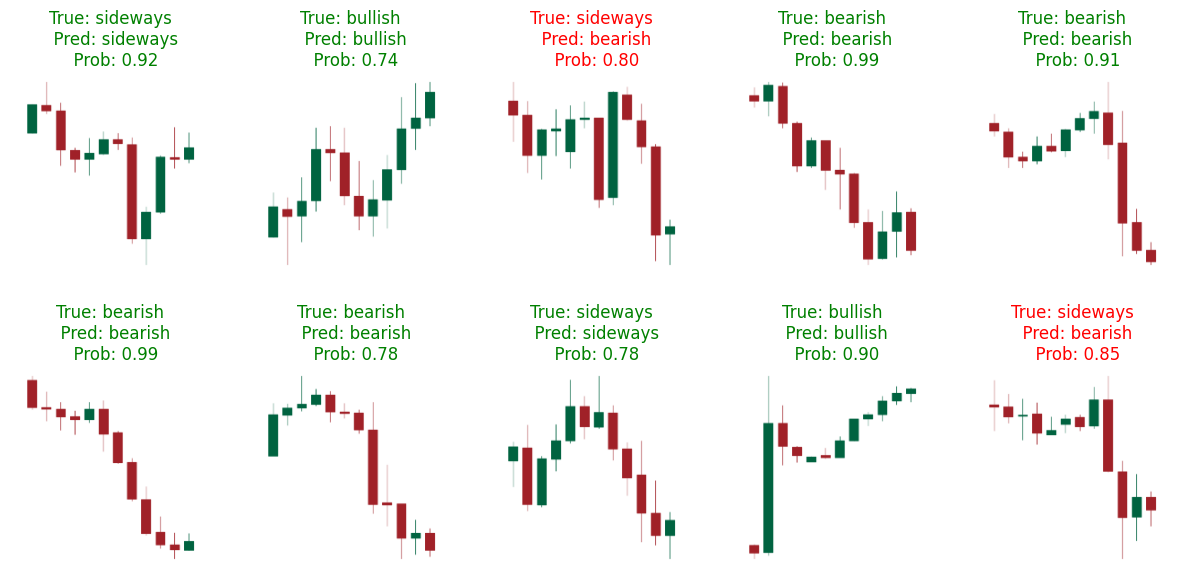

In [15]:
# Choose a random 10 indexes from the test data and compare the values

# Extract test images and labels from test_ds
test_ds_images = np.concatenate([images for images, labels in test_ds], axis=0)
test_ds_labels = np.concatenate([labels for images, labels in test_ds], axis=0)

# How many images and labels do we have?
len(test_ds_images), len(test_ds_labels)

#random.seed(42) # try changing the random seed or commenting it out for different values
random_indexes = random.sample(range(len(test_ds_images)), 10)

# Create a plot with multiple subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

# Loop through the axes of the plot
for i, ax in enumerate(axes.flatten()):
  target_index = random_indexes[i] # get a random index (this is another reason we didn't shuffle the test set)

  # Get relevant target image, label, prediction and prediction probabilities
  test_image = test_ds_images[target_index]
  test_image_truth_label = class_names[tf.argmax(test_ds_labels[target_index])]
  test_image_pred_probs = test_preds[target_index]
  test_image_pred_class = class_names[tf.argmax(test_image_pred_probs)]

  # Plot the image
  ax.imshow(test_image.astype("uint8"))

  # Create sample title
  title = f"""True: {test_image_truth_label}
  Pred: {test_image_pred_class}
  Prob: {np.max(test_image_pred_probs):.2f}"""

  # Colour the title based on correctness of pred
  ax.set_title(title,
               color="green" if test_image_truth_label == test_image_pred_class else "red")
  ax.axis("off")

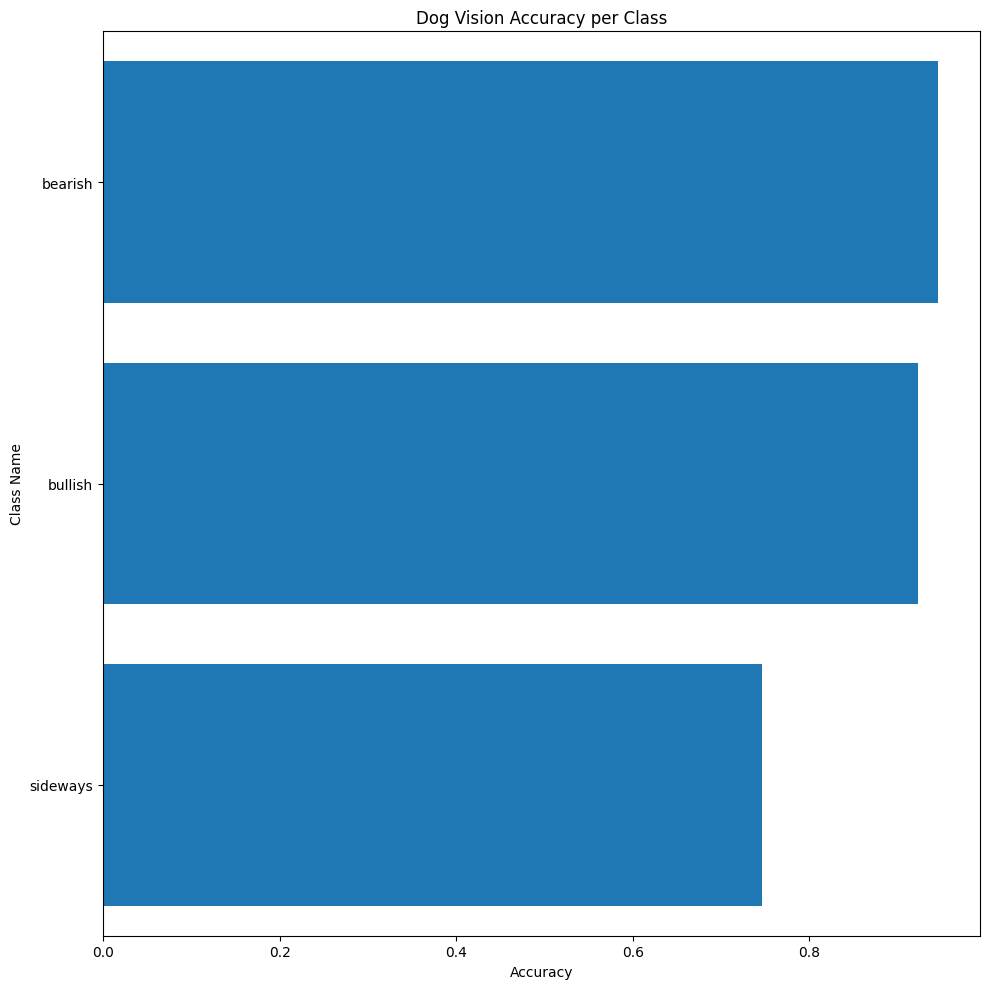

In [16]:
# Get argmax labels of test predictions and test ground truth
test_preds_labels = test_preds.argmax(axis=-1)
test_ds_labels_argmax = test_ds_labels.argmax(axis=-1)

# Get highest prediction probability of test predictions
test_pred_probs_max = tf.reduce_max(test_preds, axis=-1).numpy() # extract NumPy since pandas doesn't handle TensorFlow Tensors

# Create DataFram of test results
test_results_df = pd.DataFrame({"test_pred_label": test_preds_labels,
                                "test_pred_prob": test_pred_probs_max,
                                "test_pred_class_name": [class_names[test_pred_label] for test_pred_label in test_preds_labels],
                                "test_truth_label": test_ds_labels_argmax,
                                "test_truth_class_name": [class_names[test_truth_label] for test_truth_label in test_ds_labels_argmax]})

# Create a column whether or not the prediction matches the label
test_results_df["correct"] = test_results_df["test_pred_class_name"] == test_results_df["test_truth_class_name"]

# Calculate accuracy per class
accuracy_per_class = test_results_df.groupby("test_truth_class_name")["correct"].mean()

# Create new DataFrame to sort classes by accuracy
accuracy_per_class_df = pd.DataFrame(accuracy_per_class).reset_index().sort_values("correct", ascending=False)

# Let's create a horizontal bar chart to replicate a similar plot to the original Stanford Dogs page
plt.figure(figsize=(10, 10))
plt.barh(y=accuracy_per_class_df["test_truth_class_name"],
         width=accuracy_per_class_df["correct"])
plt.xlabel("Accuracy")
plt.ylabel("Class Name")
plt.title("Dog Vision Accuracy per Class")
plt.ylim(-0.5, len(accuracy_per_class_df["test_truth_class_name"]) - 0.5)  # Adjust y-axis limits to reduce white space
plt.gca().invert_yaxis()  # This will display the first class at the top
plt.tight_layout()
plt.show()

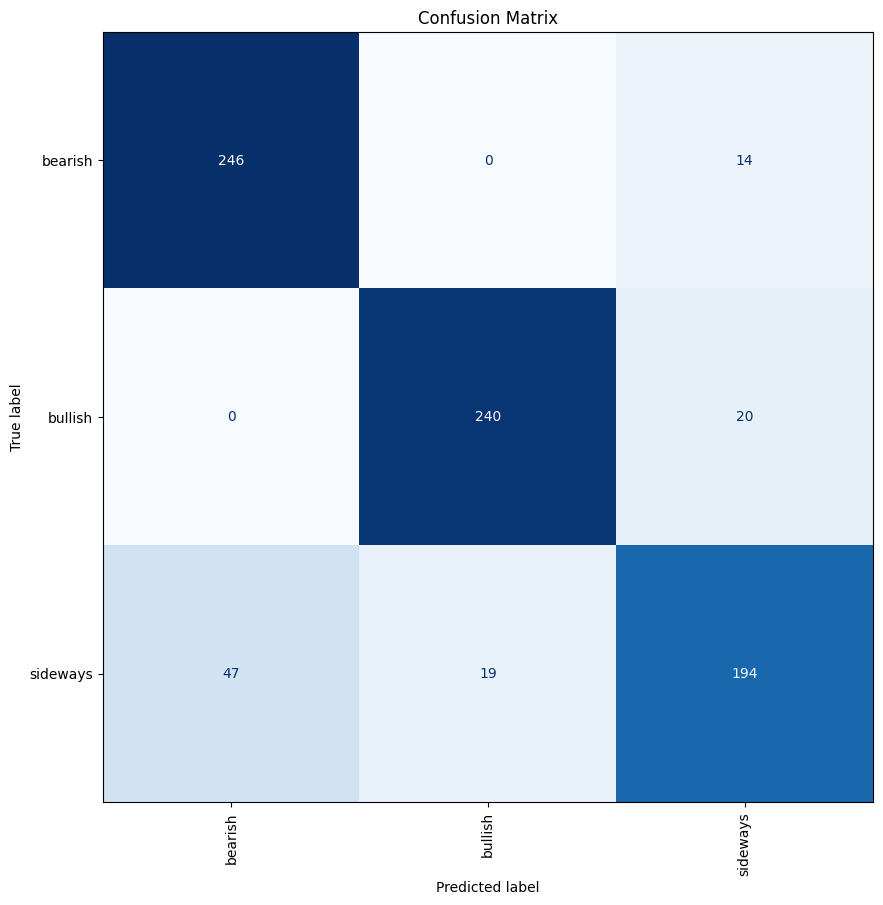

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create a confusion matrix
confusion_matrix_dog_preds = confusion_matrix(y_true=test_ds_labels_argmax, # requires all labels to be in same format (e.g. not one-hot)
                                              y_pred=test_preds_labels)
# Create a confusion matrix plot
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dog_preds,
                                                  display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Confusion Matrix")
confusion_matrix_display.plot(xticks_rotation="vertical",
                              cmap="Blues",
                              colorbar=False,
                              ax=ax);